<a href="https://colab.research.google.com/github/narevignesh/Multi-class-animal-recognition/blob/main/Multi_class_animal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#install all required libraries

!pip install kaggle
!pip install ipython
!pip install matplotlib
!pip install numpy
!pip install tensorflow
!pip install scikit-learn
!pip install Pillow

In [32]:
from IPython import get_ipython
from IPython.display import display
# %%
import kagglehub

# Purpose: Download the animal image dataset from Kaggle to use for training the model.
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)
# Result: Prints the path to the downloaded dataset files, indicating successful download.


Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
# Purpose: Import necessary libraries for data processing, visualization, and model building.
# Result: Makes the functionalities of the imported libraries available for use in subsequent cells.

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Purpose: Check and print the number of available GPUs for accelerated computation.


if tf.config.list_physical_devices('GPU'):
    print("GPU Name:", tf.config.list_physical_devices('GPU')[0].name)
    # Purpose: Print the name of the GPU if available for identification.
# Result: To see the output, run the code. Prints the number of GPUs and the name of the GPU if available.

Num GPUs Available:  1
GPU Name: /physical_device:GPU:0


In [35]:
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
# Purpose: Define the path to the downloaded dataset for easy access.
classes = os.listdir(dataset_path)
# Purpose: Retrieve the class names (animal types) from the dataset folders.
num_classes = len(classes)
# Purpose: Calculate the total number of classes (animal types) in the dataset.
print("Classes:", classes)
# Result: To see the output, run the code. Prints the names of the animal classes in the dataset.

print("Number of classes:", num_classes)
# Result: To see the output, run the code. Prints the total number of animal classes.

Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']
Number of classes: 90


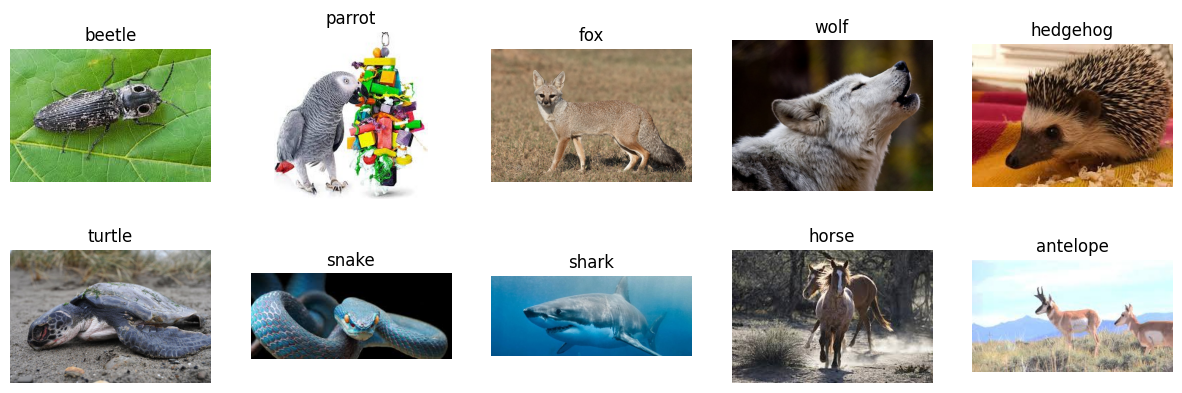

In [36]:
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes[:10]):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_files)
    image = Image.open(image_path)

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')


plt.show()
# Purpose: Display sample images from the first 10 classes of the dataset for visual inspection.
# Result: To see the output, run the code. Generates a plot containing sample images from the first 10 classes, with their corresponding class names as titles.


In [37]:
# Preprocessing the data.
# Define image size and batch_size - Trained model - MobileNetV2 - 224 x 224
img_size = (224, 224)
batch_size = 64 # There can be 64 images in a batch

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)
# Purpose: Create an ImageDataGenerator for data augmentation and preprocessing, including rescaling pixel values and splitting the data into training and validation sets.
# Result: An ImageDataGenerator object is created, configured for data augmentation and preprocessing steps.

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
# Purpose: Create a training data generator that loads images from the dataset directory, resizes them to the specified target size, applies data augmentation, and organizes them into batches for training.
# Result: A training data generator object is created, providing batches of augmented training images and their corresponding labels.

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
# Purpose: Create a validation data generator that loads images from the dataset directory, resizes them to the specified target size, and organizes them into batches for validation.
# Result: A validation data generator object is created, providing batches of validation images and their corresponding labels.

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [38]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
# Purpose: Get the mapping of class names to their respective indices.
# Result: A dictionary containing the class names as keys and their corresponding indices as values.
print(class_indices)

# Extract class names
class_names = list(class_indices.keys())
# Purpose: Extract the class names from the class indices dictionary.
# Result: A list containing the class names in the dataset.
print("Class Names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 